In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 23.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=08b086ace3b6cb8728725b9615df6f57962d59c3eb5a89ce15e84630e313470c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=86fb2a8a61bdd56328f22e747c26a04d5aea9f3bda8d2a6627a577116648569b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installat

In [8]:
# ! mkdir ~/.kaggle

In [9]:
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d sohaibanwaar1203/image-depth-estimation
#! unzip image-depth-estimation.zip

In [10]:
# -*- coding: utf-8 -*-
import torch.nn as nn
from  torch.utils.data import Dataset,DataLoader
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sns
from tqdm import tqdm,trange
from time import sleep
import warnings
from glob import glob
import os,sys
import cv2
import segmentation_models_pytorch as smp
warnings.filterwarnings("ignore")
BASEPATH = '../input/image-depth-estimation/data'


In [11]:
def read_csv(path):
    df=pd.read_csv(path,names=['image','label'],header=None)
    return df
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

df = read_csv(os.path.join(BASEPATH,'nyu2_train.csv'))
df['image'] = df['image'].apply(lambda x: '../input/image-depth-estimation/'+x)
df['label'] = df['label'].apply(lambda x: '../input/image-depth-estimation/'+x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50688 entries, 0 to 50687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   50688 non-null  object
 1   label   50688 non-null  object
dtypes: object(2)
memory usage: 792.1+ KB


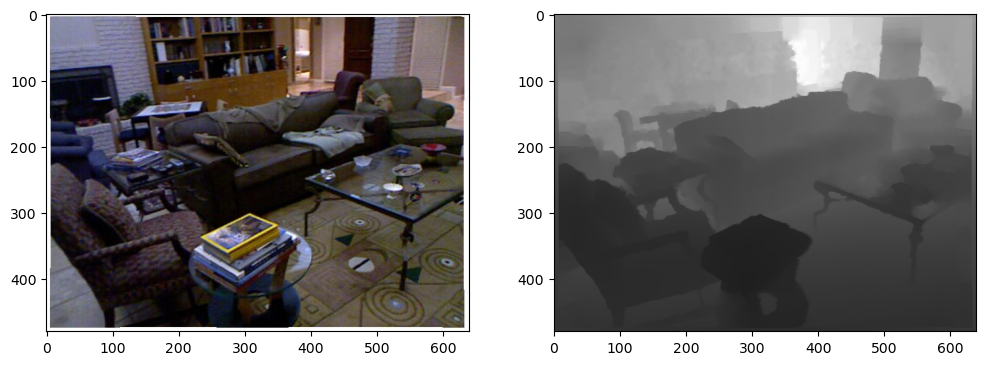

In [12]:
fig,axis = plt.subplots(1,2,figsize=(12,6))
axis[0].imshow(read_image(df.iloc[0].image))
axis[1].imshow(read_image(df.iloc[0].label))
plt.show()

In [13]:
class CFG():
    def __init__(self):
        self.lr = 3e-4
        self.epoch=15
        self.TTA_times=0
        self.batch_size = 32
        self.image_size = (192,256)
        self.seed=31
        self.fold = 5
        self.run_fold=1
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(self.device)


def setSeed(seed=31,tor=True,tensorf=False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)#only one time
    pd.core.common.random_state(seed)
    # tensorflow seed setting
    if tensorf:
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(
            intra_op_parallelism_threads=1,
            inter_op_parallelism_threads=1
        )
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        
    # pytorch seed setting
    if tor:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        
        
        
cfg = CFG()
setSeed(cfg.seed)

cuda:0


In [14]:
class Logger():
    logger_dict={}
    logger_raw_dict={}
    log_category=None
    
    def __init__(self,name,layer=0):
        self.history=pd.DataFrame()
        self.epoch_history=pd.DataFrame()
        self.current_epoch_history=pd.DataFrame()
        self.name=name
        self.epoch=0
        self.layer=str(layer)
        if self.layer not in Logger.logger_dict.keys():
            Logger.logger_dict[self.layer] = {}
            Logger.logger_raw_dict[self.layer] = {}
            
    def __call__(self,**kwargs):
        new_row = pd.DataFrame(kwargs,index=[0])
        self.current_epoch_history=self.current_epoch_history.append(new_row)
    
    def __str__(self,r=3):
        output_str=''
        if len(self.current_epoch_history)>0:
            avg_epoch = self.get_current_epoch_avg()
            for log_c in avg_epoch.index:
                output_str+= 'avg{}:{} \t'.format(log_c,f'%.{r}f'%avg_epoch[log_c])
            return output_str
        else:
            avg_epoch = self.epoch_history.iloc[-1]
            for log_c in avg_epoch.index:
                output_str+= 'avg{}:{} \t'.format(log_c,f'%.{r}f'%avg_epoch[log_c])
            return output_str
        
    def get_current_epoch_avg(self):
        return self.current_epoch_history.mean()
    
    def get_best_record(self,category='loss',mode='min',unit='epoch'):
        _history = self.epoch_history if unit == 'epoch' else self.history
        if mode == 'min':
            best_index = _history[category].idxmin()
        else:
            best_index = _history[category].idxmax()
        return best_index, _history.iloc[best_index]

    def check_best(self,category='loss',mode='min',unit='epoch'):
        _history = self.epoch_history if unit == 'epoch' else self.history
        best_index,best_record = self.get_best_record(category,mode,unit)
        return (len(_history[category])-1)==best_index

    def save_epoch(self):
        if Logger.log_category==None:
            Logger.log_category = self.current_epoch_history.columns.to_list()
        self.epoch_history=self.epoch_history.append(self.get_current_epoch_avg().copy(),ignore_index=True).reset_index(drop=True)
        self.current_epoch_history['epoch'] = self.epoch
        self.epoch += 1
        self.history = self.history.append(self.current_epoch_history.copy()).reset_index(drop=True)
        self.current_epoch_history=pd.DataFrame(columns=Logger.log_category)
        Logger.logger_dict[self.layer][self.name]=self.history
        
        
    @staticmethod
    def plot(unit='epoch',show_category=None,figsize=(6.2,3)):
        
        show_category=Logger.log_category if show_category == None else show_category
        layer_list = sorted(list(Logger.logger_dict.keys()))
        figers, axs = plt.subplots(len(layer_list),len(show_category),figsize=(len(show_category)*figsize[0],len(layer_list)*figsize[1]))
        plt.subplots_adjust(hspace=0.5)

        if len(layer_list)>1 and len(show_category)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lidx,lcidx],label=k).set(title = '{}'.format(log_c))
                        axs[lidx,lcidx].legend(loc='upper left')

        elif len(layer_list)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lidx],label=k).set(title = '{}'.format(log_c))
                        axs[lidx].legend(loc='upper left')
        elif len(show_category)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lcidx],label=k).set(title = '{}'.format(log_c))
                        axs[lcidx].legend(loc='upper left')
        else:
            keys_list=list(Logger.logger_dict[layer_list[0]].keys())
            for kidx,k in enumerate(keys_list):
                for lidx,log_c in enumerate(show_category):
                    _history=Logger.logger_dict[layer_list[0]][k]
                    _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                    sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs,label=k).set(title = '{}'.format(log_c))
                    axs.legend(loc='upper left')
        plt.show()


In [15]:
def split_train_valid(_df):
    num_sample = len(_df)
    num_split = int(num_sample*cfg.training_split)
    _df = df.sample(frac=1,random_state = cfg.seed).reset_index(drop=True)
    train_df = _df.iloc[:num_split]
    valid_df = _df.iloc[num_split:]
    return train_df, valid_df

sample_df = df.sample(n=24800,random_state=1331)
df=sample_df.reset_index(drop=True)
skf = StratifiedKFold(n_splits=cfg.fold, random_state=cfg.seed, shuffle=True)
splitlist = list(skf.split(df.index,[0]*len(df.index)))

In [16]:
class NYU2_Dataset(Dataset):
    
    def __init__(self,df, transform=None,test=False):
        self.df =  df
        self.transform = transform
        self.test = test
        self.data_id = self.df.index
        self.labels = self.df.label.values
        self.data = self.df.image.values
        self.label_transform =  A.Compose([
                                 A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
                                ])
    def get_image_pair(self,idx):
        source_image = cv2.imread(self.data[idx])
        source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
        label_image = cv2.imread(self.labels[idx])
        label_image = cv2.cvtColor(label_image, cv2.COLOR_BGR2GRAY)
        return source_image,label_image
        
    def __getitem__(self,idx):
        data_id = self.data_id[idx]
        source_image,label_image = self.get_image_pair(idx)
        
        if self.transform:
            source_image = self.transform(image=source_image)['image']
            label_image = self.label_transform(image=label_image)['image']
            label_image = label_image/255
            label_image = torch.from_numpy(np.transpose(label_image[...,None],(2,0,1))).float()

        return data_id,source_image,label_image
    
    def __len__(self):
        return len(self.data)
    
    def _working_test(self):
        _test_dataloader = DataLoader(self,
                                      batch_size=1,
                                      shuffle=False,
                                      num_workers=1,
                                      drop_last=True,
                                      pin_memory=True)
        return next(iter(_test_dataloader))


In [17]:
def get_transform():
    transform = A.Compose([
                                 A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),
                                 A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
                                 ToTensorV2()
                                ])
    return transform


def get_dataloader(train_df,valid_df):
    
    print('training data are processing..')
    train_dataset = NYU2_Dataset(train_df,transform=transform)
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=cfg.batch_size,
                                  shuffle=True,
                                  num_workers=4,
                                  drop_last=True,
                                  pin_memory=True)
        
    print('validation data are processing..')
    valid_dataset = NYU2_Dataset(valid_df,transform=transform)
    valid_dataloader = DataLoader(valid_dataset,
                                  batch_size=cfg.batch_size,
                                  shuffle=False,
                                  num_workers=4,
                                  drop_last=False,
                                  pin_memory=True)
    
    return train_dataloader,valid_dataloader
transform = get_transform()

In [18]:
class ModelInstance():
    def __init__(self,model,optimizer,loss_function,scheduler=None,clip_grad=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.certification = loss_function
        self.clip_grad = clip_grad
        
    def run_model(self,feature,label,update=True):
        feature = feature.to(cfg.device)
        label = label.to(cfg.device)
        
        if update:
            pred = self.model(feature)
        else:
            with torch.no_grad():
                pred = self.model(feature)
            
            
        loss = self.certification(pred,label)
        
        if update:
            loss.backward()
            if self.clip_grad:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=clip_grad)
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return  pred.cpu().detach(), loss.cpu().detach().item()
    
    def predict(self,feature):
        feature = feature.to(cfg.device)
        pred = self.model(feature)
        return pred.cpu().detach()
    
def create_model_instance():
    
    def certification(predict,label):
        loss = nn.MSELoss()(predict,label)
        return loss
    
    model = smp.UnetPlusPlus(
                    encoder_name="resnet50",        
                    encoder_weights='imagenet',
                    in_channels=3,                  
                    classes=1,                      
                    activation='sigmoid',
    ).to(cfg.device)
    
#     model.load_state_dict(torch.load('../input/autofocus-weighted-tmp/best_model.pkl'))
    
    optimizer = torch.optim.Adam(model.parameters(),lr=cfg.lr,amsgrad=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.4, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08, verbose=True)
    return ModelInstance(model,optimizer,certification,scheduler,None)
    
    

In [19]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

def onehot_encoding(pred):
    return pred.argmax(dim=1)

def unnormalize(images):
        return (0.5*np.array(images)+0.5)*255
def run_epoch(dataloader,epoch,logger,validmode):
    
    if validmode:
        instance.model.eval()
    else:
        instance.model.train()
        
    trange = tqdm(enumerate(dataloader),total=len(dataloader), desc='Valid' if validmode else 'Train')
    data_id,pred=None,None
    for idx, (data_id,feature,label) in trange:
        pred,loss = instance.run_model(feature,label,not validmode)
        logger(loss=loss)
        avg_log = logger.get_current_epoch_avg()
        trange.set_postfix(loss = avg_log['loss'])
    accuracy = (1-loss)*100
    print("Accuarcy",accuracy)
    logger.save_epoch()
    data_id = np.array(data_id)
    pred[0] = pred[0]*255
    fig,axis = plt.subplots(1,3,figsize=(12,4))
    axis[0].imshow(read_image(df.iloc[data_id[0]].image))
    axis[1].imshow(read_image(df.iloc[data_id[0]].label))
    axis[2].imshow(np.transpose(pred[0],(1,2,0)),cmap='gray')
    plt.show()
    

def inference(dataloader,test=False):
    
    instance.model.eval()
    
    all_pred=[]
    all_label=[]
    all_id=[]
    
    trange = tqdm(enumerate(dataloader),total=len(dataloader), desc='')
    if test:
        for idx, (data_id,feature) in trange:
            pred = instance.predict(feature)
            all_pred.append(pred)
            all_id.append(data_id)

        all_pred = np.concatenate(all_pred,axis=0)
        all_id = np.concatenate(all_id,axis=0)
        return all_id,all_pred
    
    else:
        for idx, (data_id,feature,label) in trange:
            pred,loss = instance.run_model(feature,label,update=False)
            all_pred.append(pred)
            all_label.append(label)
            all_id.append(data_id)

        all_pred = np.concatenate(all_pred,axis=0)
        all_label = np.concatenate(all_label,axis=0)
        all_id = np.concatenate(all_id,axis=0)
        return data_id,all_pred,all_label
    
    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 249MB/s]


------------ Flod 0 ------------
training data are processing..
validation data are processing..
Epoch 0/15:


Train: 100%|██████████| 620/620 [07:24<00:00,  1.39it/s, loss=0.00457]


Accuarcy 99.84176709549502


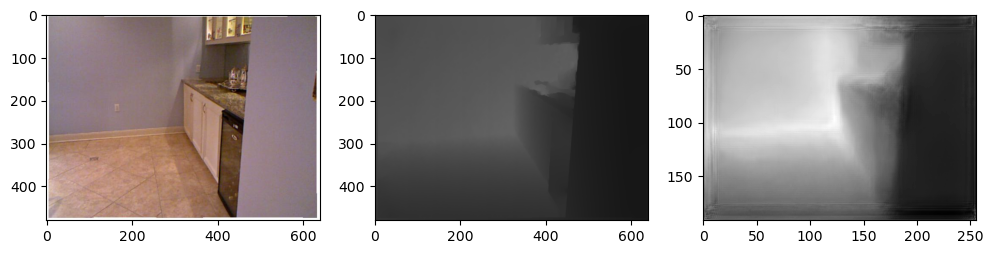

Valid: 100%|██████████| 155/155 [01:04<00:00,  2.40it/s, loss=0.00186]


Accuarcy 99.82685247668996


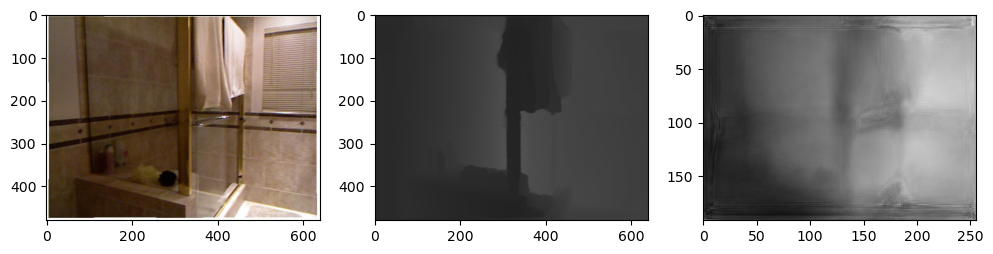

--save mode--
Epoch 1/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.00194]


Accuarcy 99.72926531918347


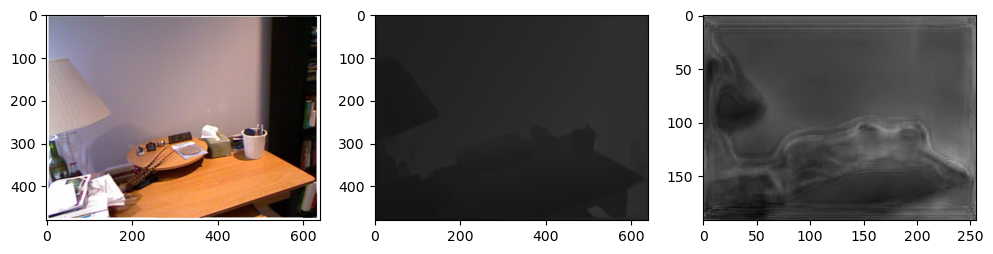

Valid: 100%|██████████| 155/155 [00:50<00:00,  3.07it/s, loss=0.00146]


Accuarcy 99.86417891923338


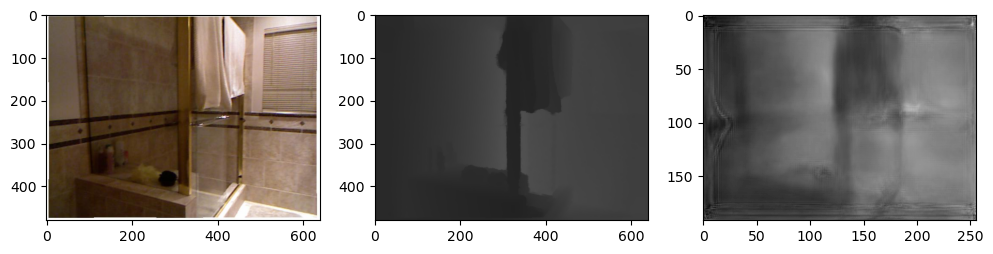

--save mode--
Epoch 2/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.00125]


Accuarcy 99.83341002371162


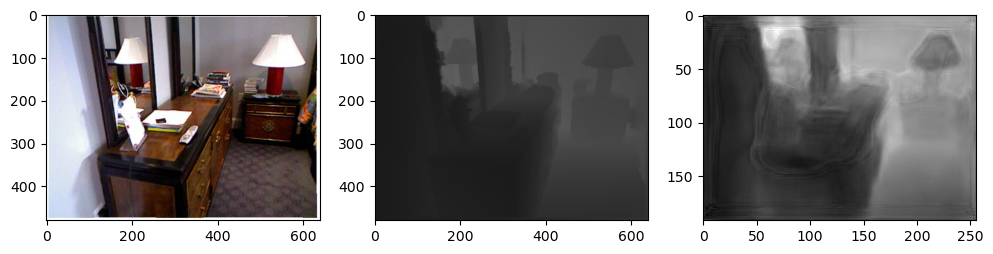

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.01it/s, loss=0.00107]


Accuarcy 99.90360299125314


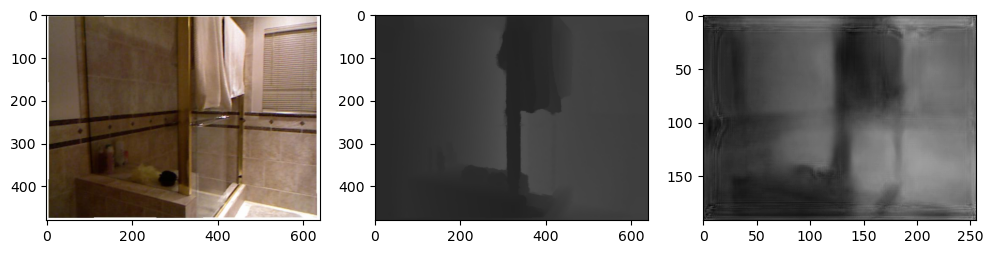

--save mode--
Epoch 3/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.00133] 


Accuarcy 99.67098489869386


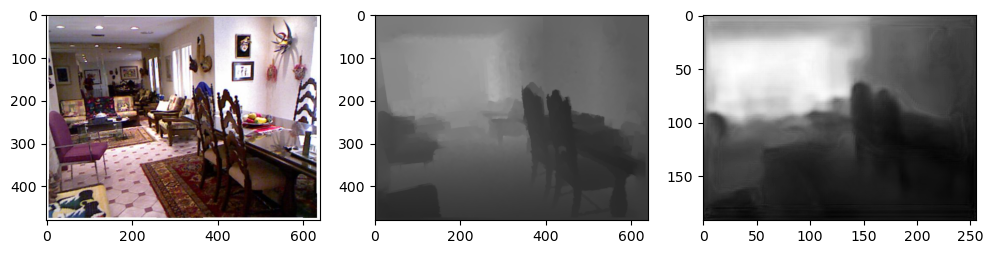

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.02it/s, loss=0.00406]


Accuarcy 99.60384028963745


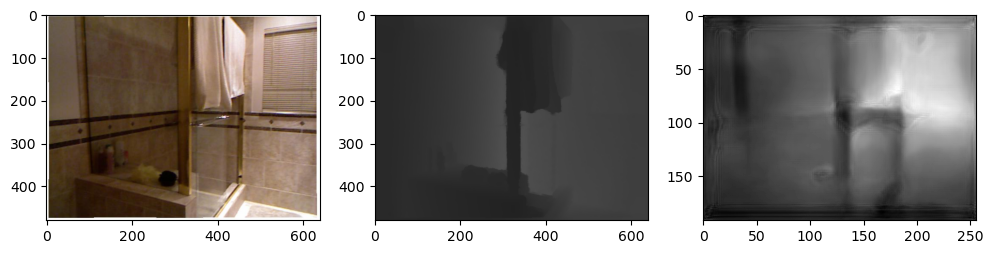

Epoch 4/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.00135]


Accuarcy 99.91705148713663


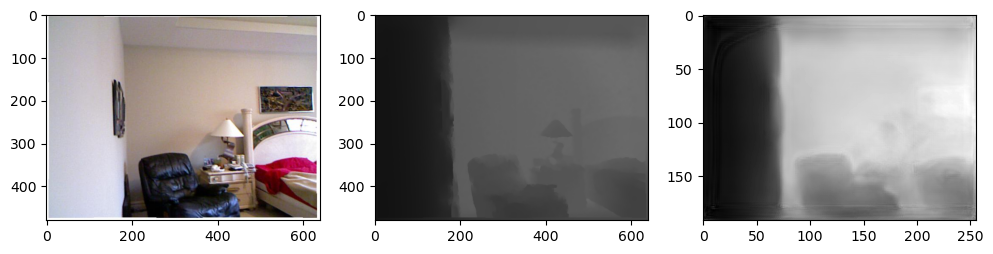

Valid: 100%|██████████| 155/155 [00:52<00:00,  2.96it/s, loss=0.000935]


Accuarcy 99.91085130022839


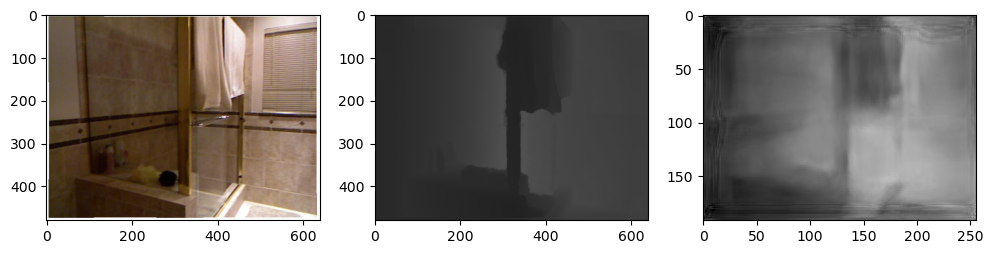

--save mode--
Epoch 5/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000745]


Accuarcy 99.9329601530917


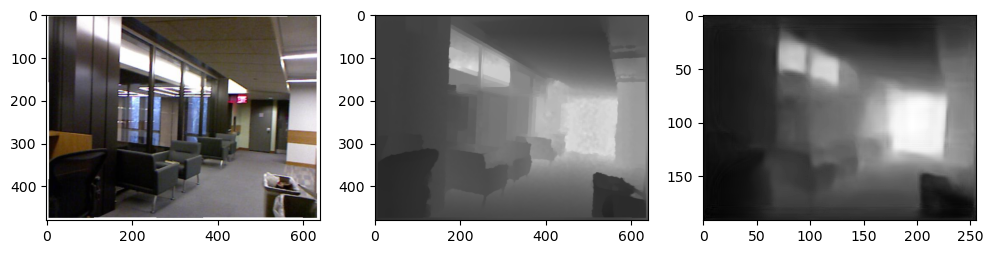

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.01it/s, loss=0.000819]


Accuarcy 99.91792887449265


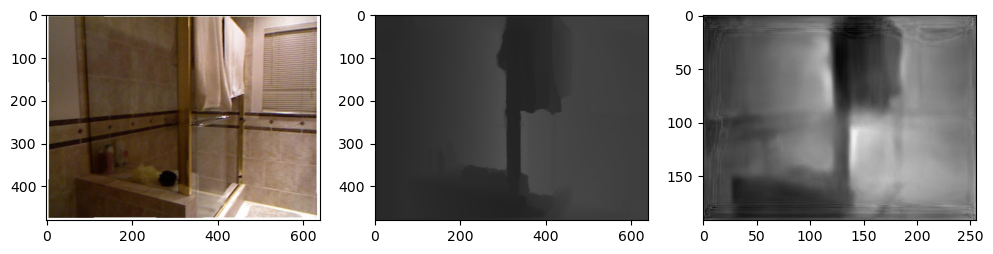

--save mode--
Epoch 6/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000584]


Accuarcy 99.93937585968524


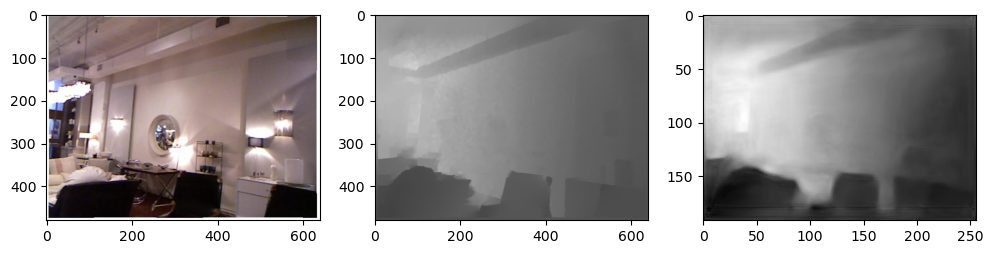

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.00it/s, loss=0.000667]


Accuarcy 99.93876640801318


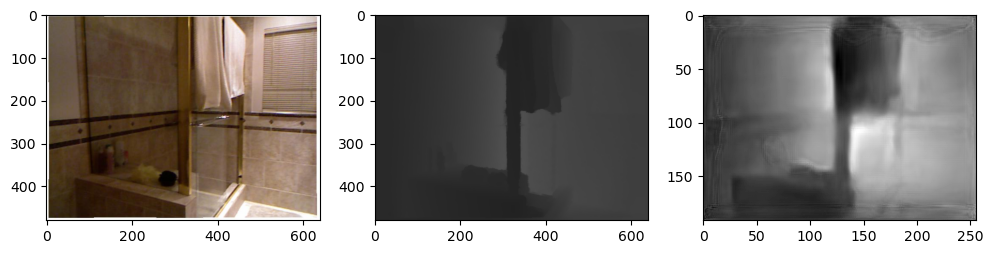

--save mode--
Epoch 7/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000499]


Accuarcy 99.96412304753903


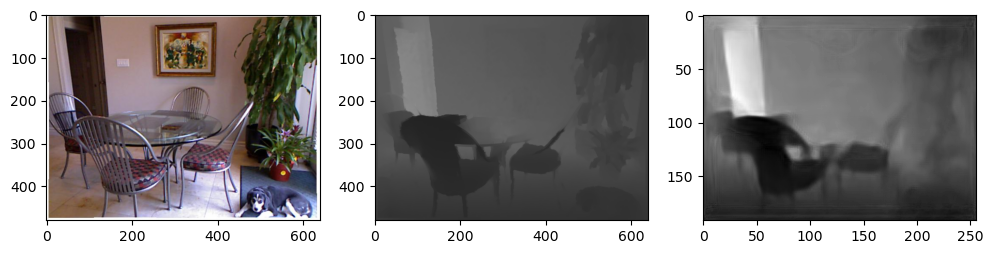

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.03it/s, loss=0.00063] 


Accuarcy 99.9451054725796


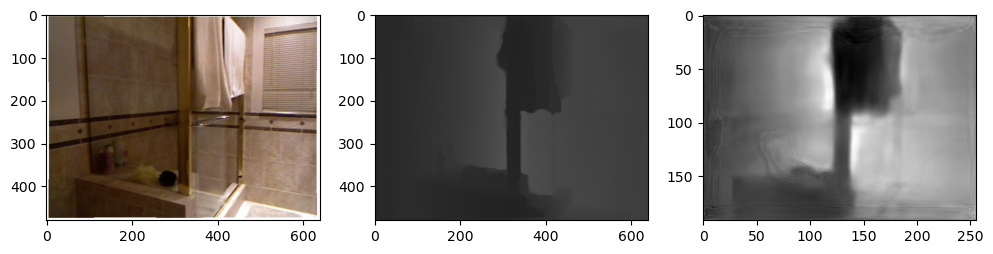

--save mode--
Epoch 8/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000443]


Accuarcy 99.94630386936478


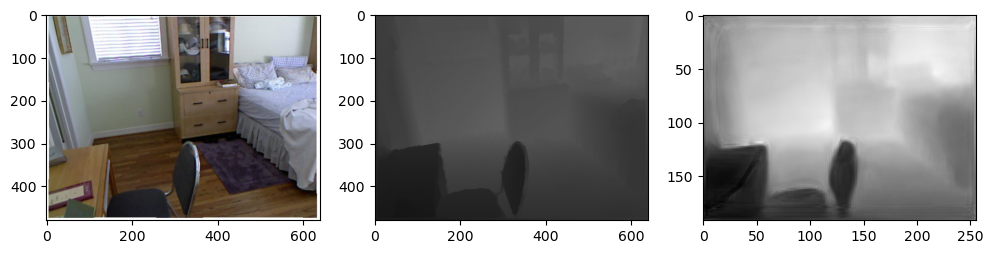

Valid: 100%|██████████| 155/155 [00:50<00:00,  3.06it/s, loss=0.000609]


Accuarcy 99.94264842243865


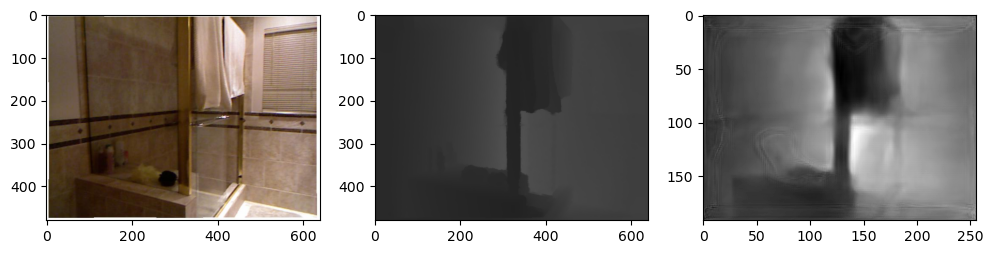

--save mode--
Epoch 9/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000395]


Accuarcy 99.93544223252684


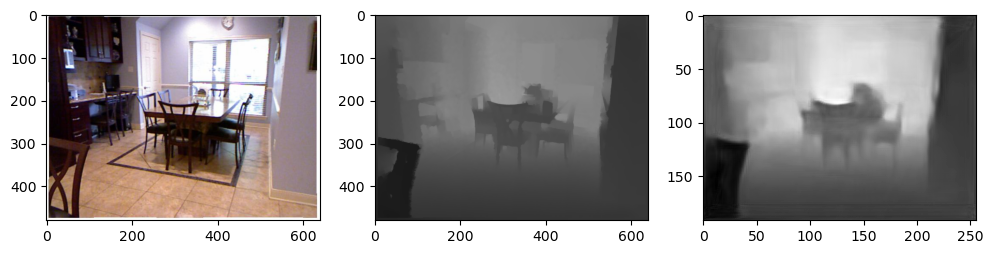

Valid: 100%|██████████| 155/155 [00:52<00:00,  2.98it/s, loss=0.000595]


Accuarcy 99.94906227802858


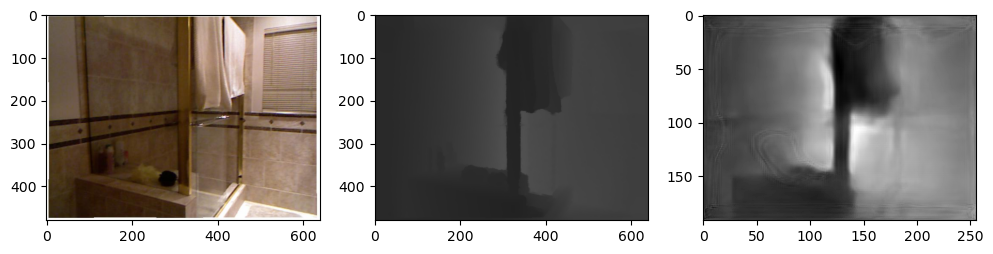

--save mode--
Epoch 10/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000357]


Accuarcy 99.96136093977839


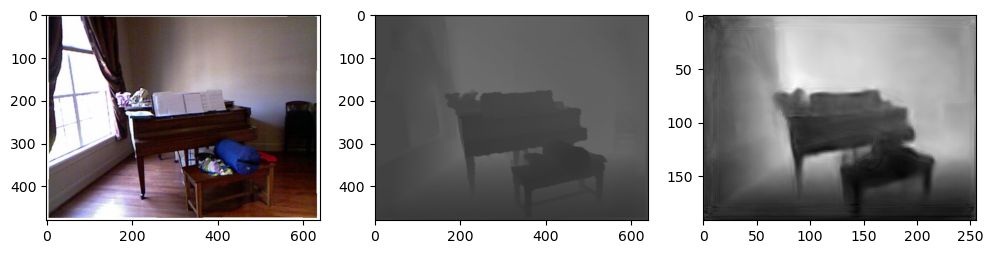

Valid: 100%|██████████| 155/155 [00:50<00:00,  3.06it/s, loss=0.000573]


Accuarcy 99.95038238121197


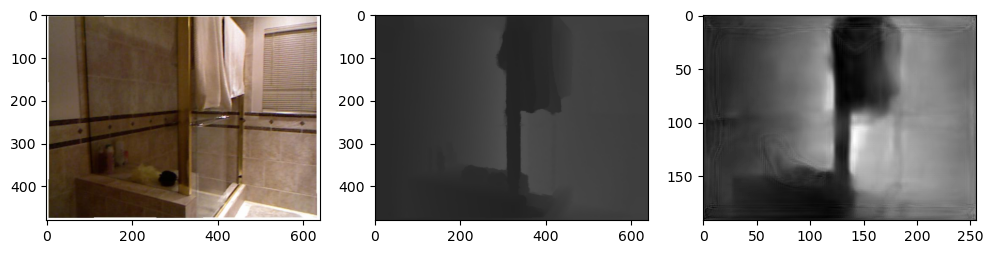

--save mode--
Epoch 11/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000339]


Accuarcy 99.96206241485197


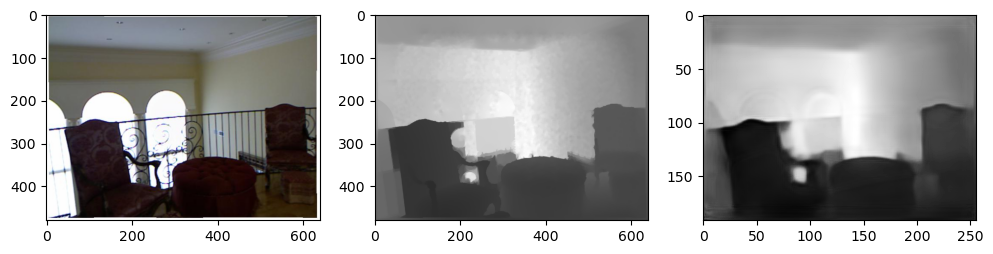

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.02it/s, loss=0.000577]


Accuarcy 99.94837132981047


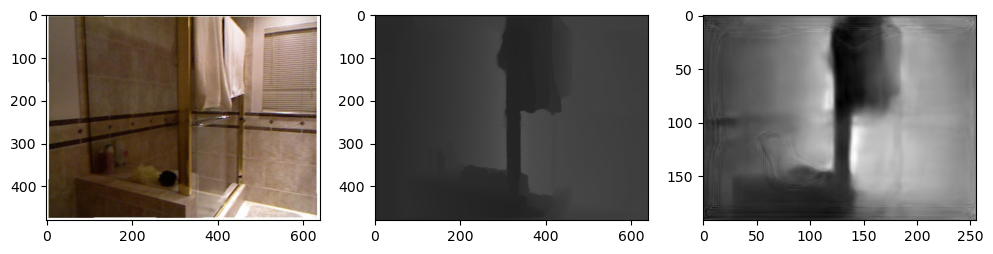

Epoch 12/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000311]


Accuarcy 99.9666730989702


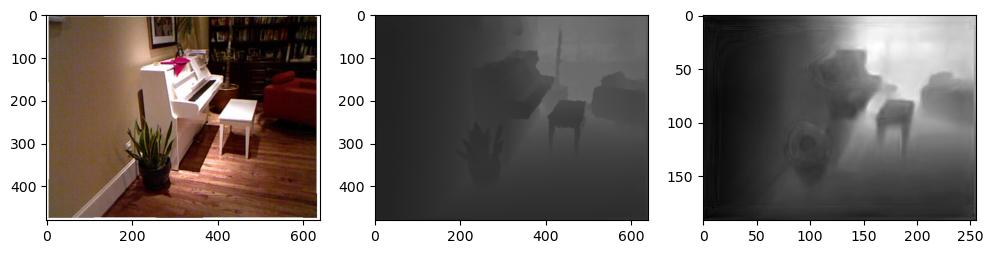

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.02it/s, loss=0.000546]


Accuarcy 99.95364459464327


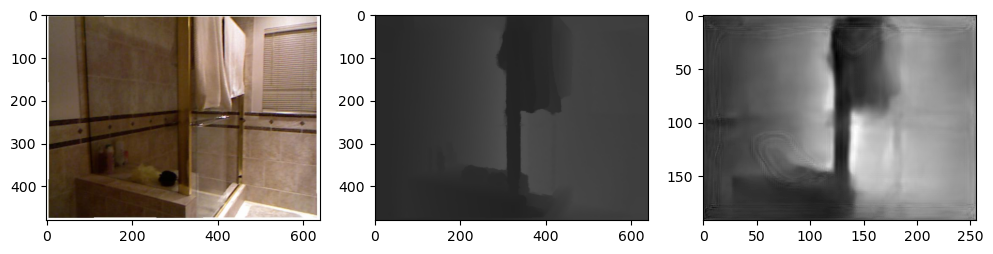

--save mode--
Epoch 13/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000284]


Accuarcy 99.97104946523905


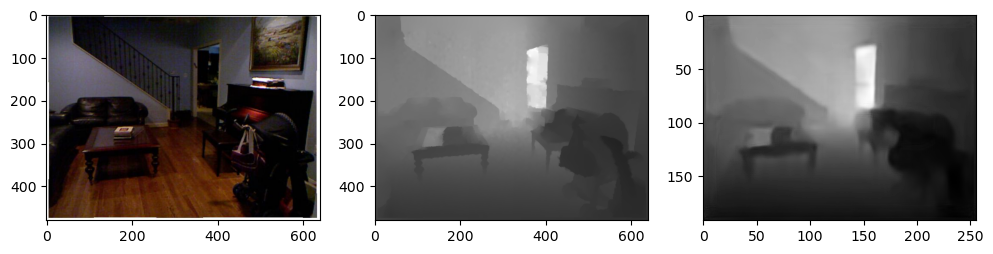

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.02it/s, loss=0.000537]


Accuarcy 99.95540925883688


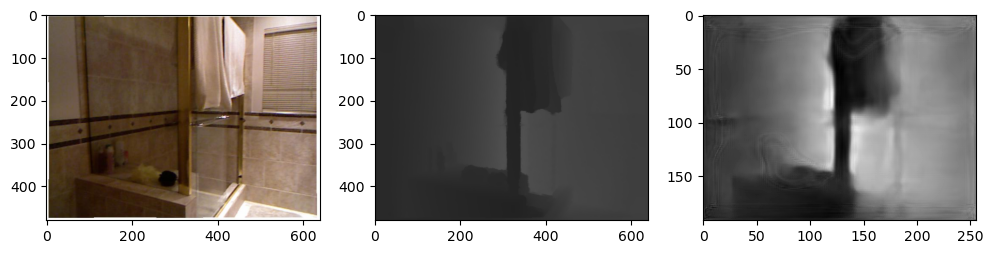

--save mode--
Epoch 14/15:


Train: 100%|██████████| 620/620 [07:16<00:00,  1.42it/s, loss=0.000266]


Accuarcy 99.97959992615506


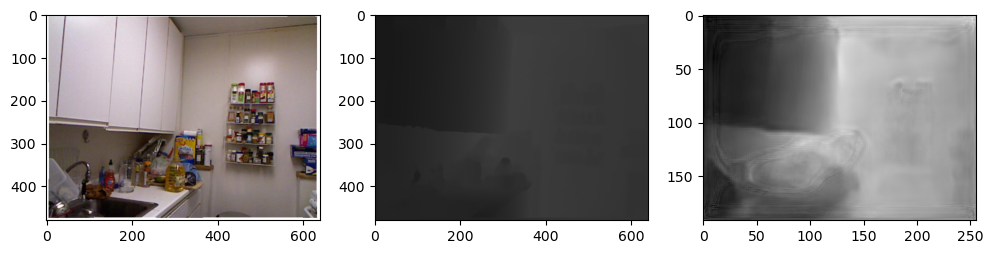

Valid: 100%|██████████| 155/155 [00:51<00:00,  3.02it/s, loss=0.000519]


Accuarcy 99.95587904704735


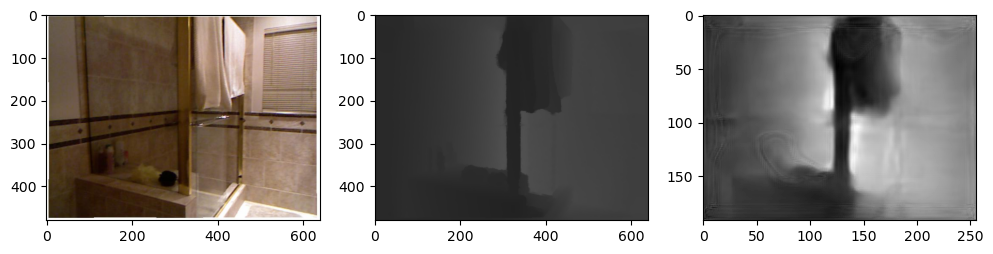

--save mode--


(14,
 loss    0.000519
 Name: 14, dtype: float64)

In [20]:
for fold,(train_index,valid_index) in enumerate(splitlist):
    instance = create_model_instance()
    training_logger=Logger('Training',fold)
    validation_logger=Logger('Validation',fold)
    
    print('------------ Flod {} ------------'.format(fold))
    train_df = df.iloc[train_index].copy()
    valid_df = df.iloc[valid_index].copy()
    train_dataloader,valid_dataloader =get_dataloader(train_df,valid_df)

    for epoch in range(cfg.epoch):
        print('Epoch {}/{}:'.format(epoch,cfg.epoch))
        run_epoch(train_dataloader,epoch,training_logger,False)
        run_epoch(valid_dataloader,epoch,validation_logger,True)
        if instance.scheduler:
            instance.scheduler.step(validation_logger.history.iloc[-1]['loss'])
        if validation_logger.check_best(category='loss',mode='min'):
            print('--save mode--')
            torch.save(instance.model.state_dict(),'best_model.pkl')
    display(validation_logger.get_best_record(category='loss',mode='min'))
    if cfg.run_fold == fold+1:
        break